In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [23]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

In [24]:
dataset_path = "./dataset"
dataset = datasets.ImageFolder(dataset_path, transform= transform)
len(dataset)  # Total number of images in the dataset

2300

In [25]:
class_names = dataset.classes
class_names  # List of class names in the dataset

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [6]:
num_classes = len(dataset.classes)
num_classes

6

In [26]:
train_size = int(len(dataset) * 0.75)
val_size = len(dataset) - train_size

train_size, val_size

(1725, 575)

In [27]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [28]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [29]:
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    print(images.shape, labels.shape)
    break  # Just to check the first batch

torch.Size([32, 3, 224, 224]) torch.Size([32])


### Model 1: CNN

In [13]:
# class CarClassifierCNN(nn.Module):
#     def __init__(self, num_classes):
#         super().__init__()
#         self.network = nn.Sequential(
#             # 1st Layer
#             nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), #output (16,224,224)
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #output (16,112,112)

#             # 2nd Layer
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), #output (32,112,112)
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #output (32,56,56)

#             # 3rd Layer
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), #output (32,56,56)
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #output (64,28,28)

#             nn.Flatten(),  # Flatten the output for the fully connected layer
#             nn.Linear(64 * 28 * 28, 512),  # Fully connected
#             nn.Relu(),
#             nn.Linear(512, num_classes)  # Output layer for classification

#         )
#     def forward(self, x):
#         x = self.network(x)
#         return x

In [14]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [15]:
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
images.size(0) # batch size

32

In [11]:
def train_model(model, criterion, optimizer, epochs=10):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num , (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            #Zero the parameters gradients
            optimizer.zero_grad()

            #Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            #Backward pass and optimization
            loss.backward()
            optimizer.step()

            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg_Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

In [ ]:
train_model(model, criterion, optimizer, epochs=5)

### Model 2: CNN with Regularization

In [ ]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [ ]:
model = CarClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

all_labels, all_predictions = train_model(model, criterion, optimizer,  epochs=5)

Batch: 10, Epoch: 1, Loss: 12.46
Batch: 20, Epoch: 1, Loss: 3.88
Batch: 30, Epoch: 1, Loss: 1.88
Batch: 40, Epoch: 1, Loss: 1.67
Batch: 50, Epoch: 1, Loss: 1.48
Epoch [1/5], Avg_Loss: 8.1285
*** Validation Accuracy: 45.91% ***
Batch: 10, Epoch: 2, Loss: 0.96
Batch: 20, Epoch: 2, Loss: 1.67
Batch: 30, Epoch: 2, Loss: 1.14
Batch: 40, Epoch: 2, Loss: 1.30
Batch: 50, Epoch: 2, Loss: 0.93
Epoch [2/5], Avg_Loss: 1.2756
*** Validation Accuracy: 51.30% ***
Batch: 10, Epoch: 3, Loss: 0.90
Batch: 20, Epoch: 3, Loss: 1.34
Batch: 30, Epoch: 3, Loss: 0.98
Batch: 40, Epoch: 3, Loss: 1.03
Batch: 50, Epoch: 3, Loss: 1.20
Epoch [3/5], Avg_Loss: 1.1578
*** Validation Accuracy: 47.65% ***
Batch: 10, Epoch: 4, Loss: 1.10
Batch: 20, Epoch: 4, Loss: 1.43
Batch: 30, Epoch: 4, Loss: 1.03
Batch: 40, Epoch: 4, Loss: 1.40
Batch: 50, Epoch: 4, Loss: 1.17
Epoch [4/5], Avg_Loss: 1.0636
*** Validation Accuracy: 51.48% ***
Batch: 10, Epoch: 5, Loss: 1.41
Batch: 20, Epoch: 5, Loss: 0.62
Batch: 30, Epoch: 5, Loss: 0.77

### Model 3: Transfer Learning with EfficientNet

In [12]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

1280

In [13]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x  

In [14]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.68
Batch: 20, Epoch: 1, Loss: 1.53
Batch: 30, Epoch: 1, Loss: 1.39
Batch: 40, Epoch: 1, Loss: 1.39
Batch: 50, Epoch: 1, Loss: 1.41
Epoch [1/10], Avg_Loss: 1.4747
*** Validation Accuracy: 55.48% ***
Batch: 10, Epoch: 2, Loss: 1.23
Batch: 20, Epoch: 2, Loss: 1.10
Batch: 30, Epoch: 2, Loss: 1.08
Batch: 40, Epoch: 2, Loss: 1.12
Batch: 50, Epoch: 2, Loss: 1.09
Epoch [2/10], Avg_Loss: 1.1426
*** Validation Accuracy: 61.22% ***
Batch: 10, Epoch: 3, Loss: 1.02
Batch: 20, Epoch: 3, Loss: 0.80
Batch: 30, Epoch: 3, Loss: 0.95
Batch: 40, Epoch: 3, Loss: 1.00
Batch: 50, Epoch: 3, Loss: 0.95
Epoch [3/10], Avg_Loss: 1.0404
*** Validation Accuracy: 61.04% ***
Batch: 10, Epoch: 4, Loss: 1.04
Batch: 20, Epoch: 4, Loss: 1.07
Batch: 30, Epoch: 4, Loss: 0.96
Batch: 40, Epoch: 4, Loss: 1.13
Batch: 50, Epoch: 4, Loss: 0.87
Epoch [4/10], Avg_Loss: 0.9879
*** Validation Accuracy: 62.96% ***
Batch: 10, Epoch: 5, Loss: 0.98
Batch: 20, Epoch: 5, Loss: 1.02
Batch: 30, Epoch: 5, Loss: 0

### Model 4: Transfer Learning with ResNet

In [15]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [17]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=5)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\mustafa.mohammed/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:24<00:00, 4.18MB/s]


Batch: 10, Epoch: 1, Loss: 1.29
Batch: 20, Epoch: 1, Loss: 0.70
Batch: 30, Epoch: 1, Loss: 0.95
Batch: 40, Epoch: 1, Loss: 0.54
Batch: 50, Epoch: 1, Loss: 0.84
Epoch [1/5], Avg_Loss: 0.8872
*** Validation Accuracy: 70.43% ***
Batch: 10, Epoch: 2, Loss: 0.66
Batch: 20, Epoch: 2, Loss: 0.48
Batch: 30, Epoch: 2, Loss: 0.43
Batch: 40, Epoch: 2, Loss: 0.80
Batch: 50, Epoch: 2, Loss: 0.70
Epoch [2/5], Avg_Loss: 0.5054
*** Validation Accuracy: 72.70% ***
Batch: 10, Epoch: 3, Loss: 0.29
Batch: 20, Epoch: 3, Loss: 0.24
Batch: 30, Epoch: 3, Loss: 0.30
Batch: 40, Epoch: 3, Loss: 0.38
Batch: 50, Epoch: 3, Loss: 0.37
Epoch [3/5], Avg_Loss: 0.3557
*** Validation Accuracy: 76.87% ***
Batch: 10, Epoch: 4, Loss: 0.54
Batch: 20, Epoch: 4, Loss: 0.13
Batch: 30, Epoch: 4, Loss: 0.25
Batch: 40, Epoch: 4, Loss: 0.54
Batch: 50, Epoch: 4, Loss: 0.27
Epoch [4/5], Avg_Loss: 0.2940
*** Validation Accuracy: 76.70% ***
Batch: 10, Epoch: 5, Loss: 0.19
Batch: 20, Epoch: 5, Loss: 0.27
Batch: 30, Epoch: 5, Loss: 0.21


#### I ran hyperparameter tunning in another notebook and figured that the best parameters for resnet models are (1) Dropout rate = 0.2 (2) Learning Rate = 0.005

So now let's train the model once again with these best parameters

In [32]:
model = CarClassifierResNet(num_classes=num_classes, dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)

labels, predictions = train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epoch: 1, Loss: 0.96
Batch: 20, Epoch: 1, Loss: 0.76
Batch: 30, Epoch: 1, Loss: 0.93
Batch: 40, Epoch: 1, Loss: 0.59
Batch: 50, Epoch: 1, Loss: 0.92
Epoch [1/5], Avg_Loss: 0.9004
*** Validation Accuracy: 65.57% ***
Batch: 10, Epoch: 2, Loss: 0.55
Batch: 20, Epoch: 2, Loss: 0.53
Batch: 30, Epoch: 2, Loss: 0.63
Batch: 40, Epoch: 2, Loss: 0.29
Batch: 50, Epoch: 2, Loss: 0.23
Epoch [2/5], Avg_Loss: 0.5145
*** Validation Accuracy: 74.43% ***
Batch: 10, Epoch: 3, Loss: 0.55
Batch: 20, Epoch: 3, Loss: 0.36
Batch: 30, Epoch: 3, Loss: 0.32
Batch: 40, Epoch: 3, Loss: 0.28
Batch: 50, Epoch: 3, Loss: 0.43
Epoch [3/5], Avg_Loss: 0.3703
*** Validation Accuracy: 75.13% ***
Batch: 10, Epoch: 4, Loss: 0.24
Batch: 20, Epoch: 4, Loss: 0.33
Batch: 30, Epoch: 4, Loss: 0.40
Batch: 40, Epoch: 4, Loss: 0.11
Batch: 50, Epoch: 4, Loss: 0.22
Epoch [4/5], Avg_Loss: 0.2606
*** Validation Accuracy: 78.26% ***
Batch: 10, Epoch: 5, Loss: 0.11
Batch: 20, Epoch: 5, Loss: 0.07
Batch: 30, Epoch: 5, Loss: 0.22


In [33]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.86      0.88       125
           1       0.81      0.73      0.77       111
           2       0.78      0.92      0.84       107
           3       0.63      0.91      0.74        77
           4       0.87      0.40      0.55        83
           5       0.73      0.83      0.78        72

    accuracy                           0.78       575
   macro avg       0.79      0.77      0.76       575
weighted avg       0.80      0.78      0.77       575



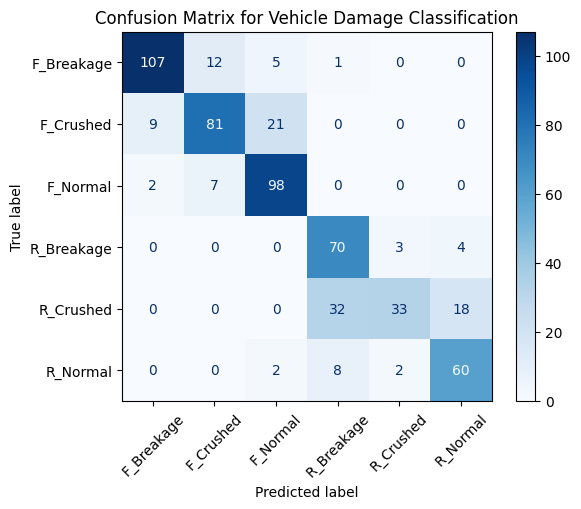

In [34]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

In [35]:
torch.save(model.state_dict(), 'saved_model.pth')